# Monte Carlo class usage

![Landing point dispersion elipses](https://github.com/RocketPy-Team/RocketPy/raw/master/docs/notebooks/dispersion_analysis/dispersion_analysis_outputs/valetudo_rocket_v0.svg)

This is an advanced use of RocketPy. This notebook runs a Monte Carlo analysis and predicts probability distributions of the rocket's landing point, apogee and other relevant information. 

The `MonteCarlo` class simplifies the process of performing Monte Carlo simulations. The idea is to take the already defined classes for a standard flight simulation, and create the so called ``Stochastic`` classes, which are used to run the Monte Carlo analysis.

This class offers extensive capabilities, and this example notebook covers as many as possible.
For a deeper understanding, we recommend checking the class [documentation](https://docs.rocketpy.org/en/latest/).

For a more comprehensive conceptual understanding of Monte Carlo Simulations, refer to RocketPy's main reference: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331).



In [1]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2

First, let's import the necessary libraries

In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
import datetime

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib widget

## Step 1: Standard Simulation


We will first create a standard RocketPy simulation objects (e.g. Environment, SolidMotor, etc.) to then create the Stochastic objects.

The standard objects created here are the same as in the [First Simulation Page](https://docs.rocketpy.org/en/latest/user/first_simulation.html) of our documentation, so you can go through that if you want to understand what is done in more detail.

The only difference here is that we will use a `Environment` with atmospheric model type `Ensemble`. This allows us to run the Monte Carlo analysis with different ensemble members, which are different atmospheric profiles.

We will do it all in one single cell for simplicity.

In [4]:
# Environment
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
# env.set_atmospheric_model(type="Ensemble", file="GEFS")

# Motor
motor = SolidMotor(
    thrust_source="../../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

# Rocket
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Flight
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

/home/phmb/github/RocketPy/rocketpy/mathutils/function.py:3120: UserWarning: Extrapolation method set to 'constant' because the linear method is not supported.
  warnings.warn(


Total Impulse of the Solid Motor: 6026.35 Ns


Lets check the trajectory of the Flight.

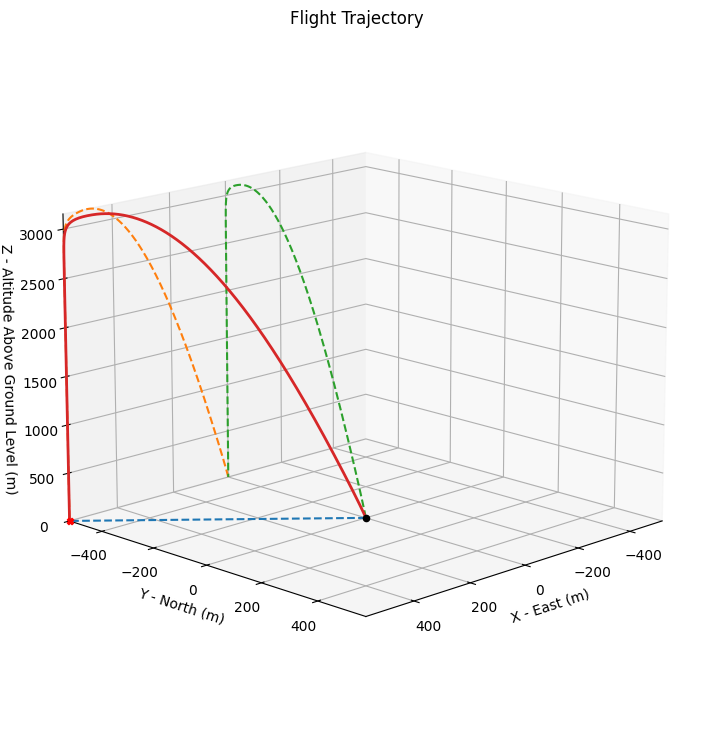

In [5]:
test_flight.plots.trajectory_3d()

The flight trajectory above represents the nominal trajectory of the rocket, without any uncertainties.


## Step 2: Stochastic Objects

For each RocketPy object, we will create a ``Stochastic`` counterpart that extends the initial model, allowing us to define the uncertainties of each input parameter.

Please refer to the [Working with Stochastic Objects]() page on RocketPy`s documentation for a more detailed explanation.

### Stochastic Environment


Starting with the `Environment` object, we will create a `StochasticEnvironment` to specify its uncertainties.

In this first example, we will specify the ensemble member and wind velocities factor.

Since the ensemble member is a discrete value, **only list type inputs are permitted**. The list will contain the ensemble numbers to be randomly selected during the Monte Carlo simulation. This means that in each iteration, a different ensemble member will be chosen.

<!-- The wind velocities factor are also special inputs. They are used to scale the wind velocities in each axis. The factor inputs can only be tuples or lists, since it has no nominal value to get from the standard. Lets scale the wind by a factor of 1.00000 ± 0.2 -->

In [6]:
stochastic_env = StochasticEnvironment(
    environment=env,
    # ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                113
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.3897
	longitude                -8.288964
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)


<div class="alert alert-block alert-info"> 

#### NOTE

Always check the `.visualize_attributes()` method of each stochastic object to verify the uncertainties were correctly set.

</div>



Just to illustrate the potential of this technique, let's randomly generate 5 instances of the environment using the `create_object` method.

For each instance, we will calculate the wind speed at 1km altitude and store the results in a list.

In [7]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[0, 0, 0, 0, 0]


As you can see, the wind speed varies between ensemble members.
This demonstrates how the Monte Carlo simulation can capture the variability in wind conditions due to different ensemble members.


### Motor


We can now create a `StochasticSolidMotor` object to define the uncertainties associated with the motor.
In this example, we will apply more complex uncertainties to the motor parameters.

The `StochasticSolidMotor` also has one special parameter which is the `total_impulse`. It lets us alter the total impulse of the motor while maintaining the thrust curve shape. This is particularly useful for motor uncertainties.

In [8]:
stochastic_motor = StochasticSolidMotor(
    solid_motor=motor,
    burn_start_time=(0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    3.9
	center_of_dry_mass_position      0.317
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.125
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.125
	dry_I_23                         0
	dry_I_33                         0.002
	dry_mass                         1.815
	grain_number                     5
	interpolate                      linear
	thrust_source                    [[0, 0], [0.055, 100.0], [0.092, 1500.0], [0.1, 2000.0], [0.15, 2200.0], [0.2, 1800.0], [0.5, 1950.0], [1.0, 2034.0], [1.5, 2000.0], [2.0, 1900.0], [2.5, 1760.0], [2.9, 1700.0], [3.0, 1650.0], [3.3, 530.0], [3.4, 350.0], [3.9, 0.0]]

Stochastic Attributes:
	burn_start_time                  0.00000 ± 0.10000 (binomial)
	grain_density                    1815.00000 ± 50.00000 (normal)
	grain_ini

<div class="alert alert-block alert-info"> 

#### NOTE

Pay special attention to how different input types are interpreted in the `StochasticSolidMotor` object by checking the printed object:


<!-- - ``thrust_source`` was given as a list of 3 items, and is saved as is. This means that the simulation will randomly chose one item of that list, as desired -->

- ``burn_start_time`` was given as a tuple of 3 items, specifying the nominal value, the standard deviation and the distribuition type

- ``total_impulse`` was given as a tuple of 2 numbers, so the distribuition type was set to the default: `normal`

- All other values set for the other parameters in the constructor are simple values, which means they are interpreted as standard deviation and the nominal value is taken from the ``motor``

- The remaining parameters that are printed are just the nominal values from the ``motor``. In the ``Stochastic`` object they are saved as a list of one item

 </div>



Once again, we can illustrate the power of stochastic modeling by generating multiple instances of the `SolidMotor` class using the `StochasticSolidMotor` object.
For each instance, we will calculate the total impulse and store the results in a list. This will show how the uncertainties in the motor parameters affect the total impulse over multiple iterations.


In [9]:
total_impulse = []
for i in range(5):
    rnd_motor = stochastic_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[5581.887614734133, 5707.92377609551, 7243.097224168756, 7310.235916395157, 5933.99146546768]


### Rocket


We can now create a `StochasticRocket` object to define the uncertainties associated with the rocket.

In [10]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)


The `StochasticRocket` still needs to have its aerodynamic surfaces and parachutes added. 

We can also create stochastic models for each aerodynamic surface, although this is not mandatory.

In [11]:
stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

Then we must add them to our stochastic rocket, much like we do in the normal Rocket.



In [12]:
stochastic_rocket.add_motor(stochastic_motor, position=0.001)
stochastic_rocket.add_nose(stochastic_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.set_rail_buttons(
    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

<div class="alert alert-block alert-info"> 

#### NOTE

The `position` arguments behave just like the other ``Stochastic`` classes parameters

 </div>



Now lets check how the `StochasticRocket` handled all these additions

In [13]:
stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)



### Flight


After defining the `Flight`, we can create the corresponding `Stochastic` object to define the uncertainties of the input parameters.

In [14]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5

Stochastic Attributes:
	heading               53.00000 ± 2.00000 (normal)
	inclination           84.70000 ± 1.00000 (normal)


### Step 2: Starting the Monte Carlo Simulations


First, let's invoke the `MonteCarlo` class, we are going to need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [15]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt
A total of 1000 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt                                           


/home/phmb/github/RocketPy/rocketpy/simulation/monte_carlo.py:122: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Finally, let's simulate our flights. 
We can run the simulations using the method `MonteCarlo.simulate()`.

Set `append=False` to overwrite the previous results, or `append=True` to add the new results to the previous ones.


In [16]:
test_dispersion.simulate(
    number_of_simulations=1000,
    append=False,
    parallel=True,
    n_workers=None,
)

Starting Monte Carlo analysis                                                                           
Current iteration: 000999 | Average Time per Iteration: 0.646 s | Estimated time left: 0 s  
Completed 1000 iterations. In total, 1000 simulations are exported.
Total wall time: 649.0 s
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [16]:
# You only need to import results if you did not run the simulations
test_dispersion.import_results()

A total of 1000 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt                                           
The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt


In [17]:
test_dispersion.num_of_loaded_sims

1000

In [18]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  1000
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
              apogee_time          25.397           2.120
          max_mach_number           0.862           0.140
                 apogee_x         483.182         110.462
                 apogee_y         377.542          89.190
                   apogee        3375.793         644.509
                 x_impact         564.464         121.888
 initial_stability_margin           2.575           0.085
                  t_final         306.119          36.231
          impact_velocity          -5.242           0.066
     out_of_rail_velocity          25.858           2.350
     lateral_surface_wind           0.000           0.000
     frontal_surface_wind           0.000           0.000
         out_of_rail_time           0.359

Secondly, we can plot the results of the simulations.


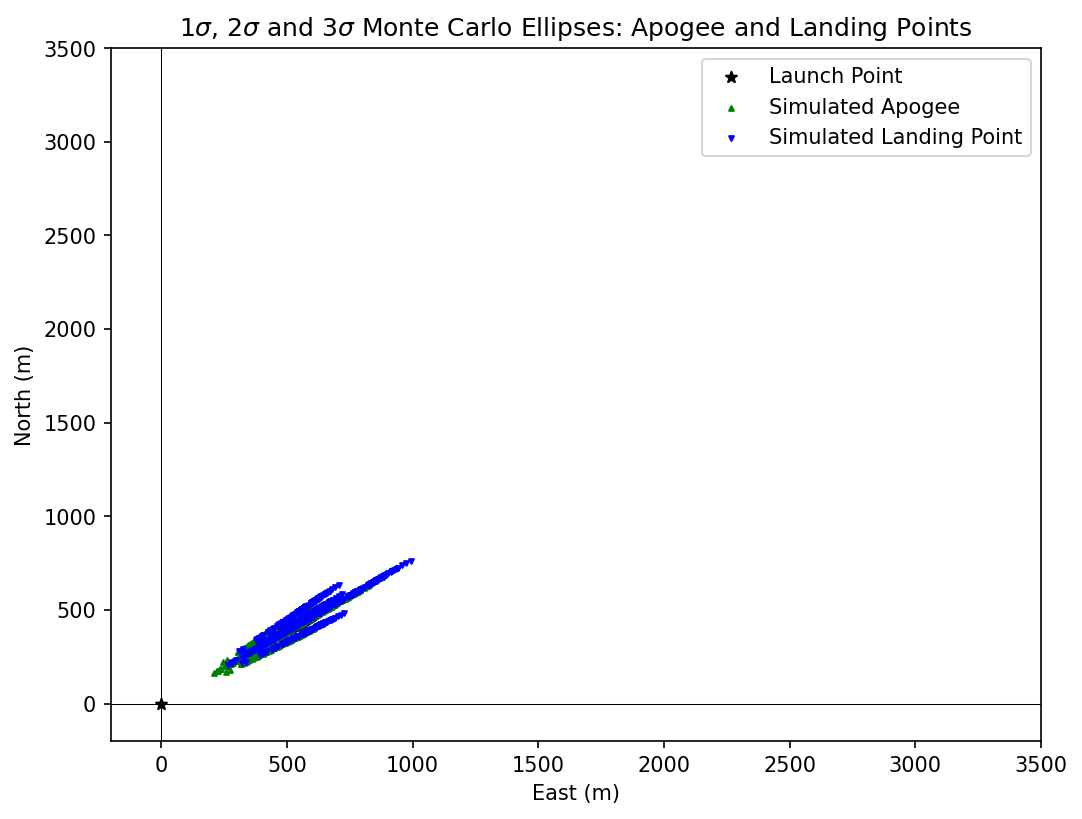

In [19]:
test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))

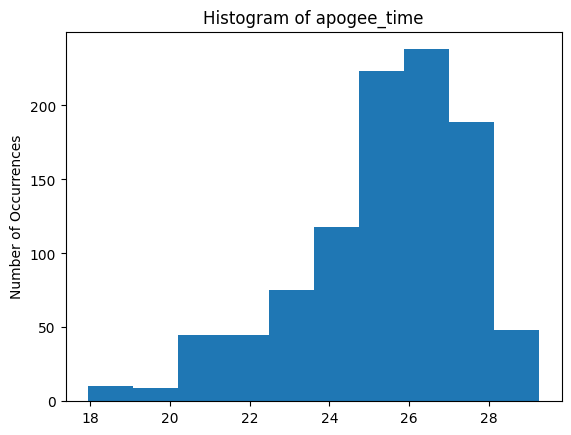

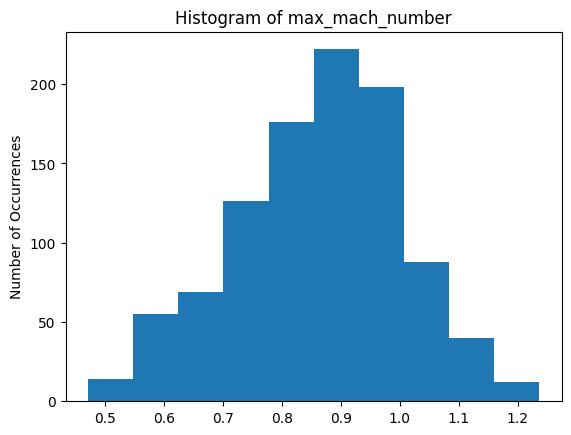

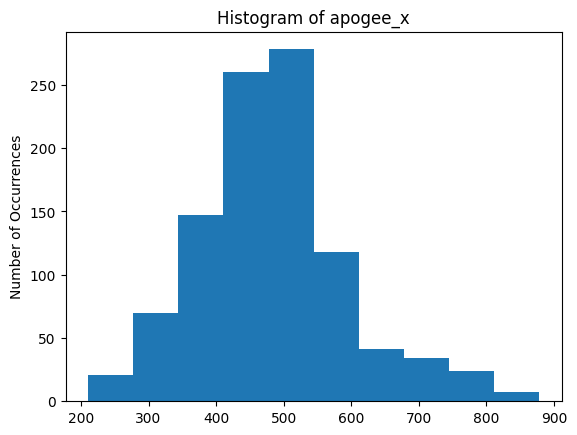

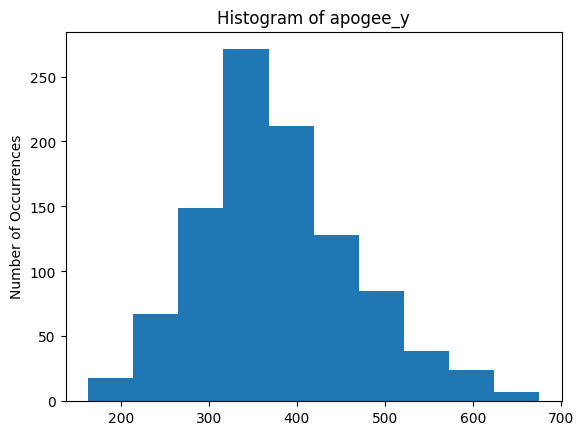

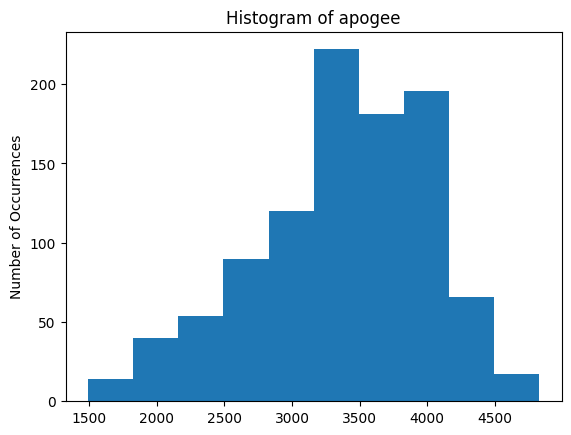

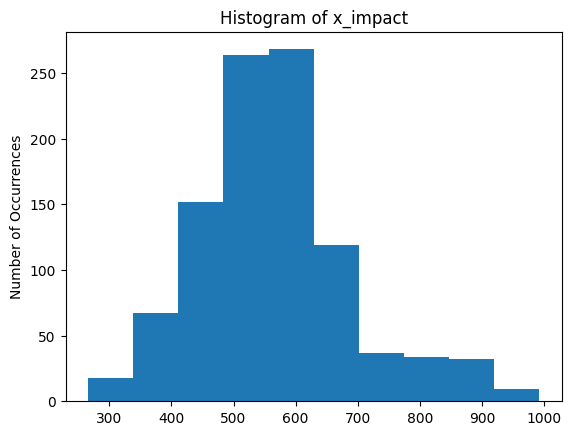

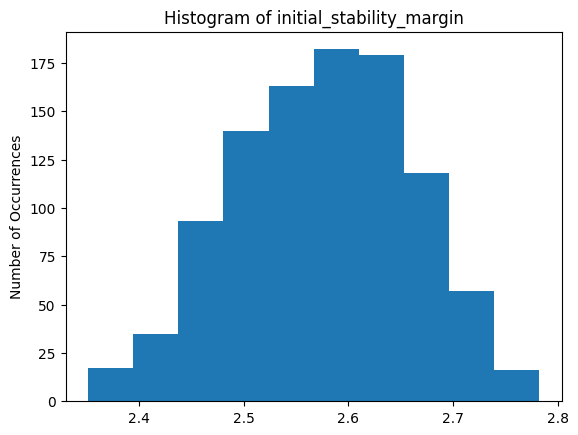

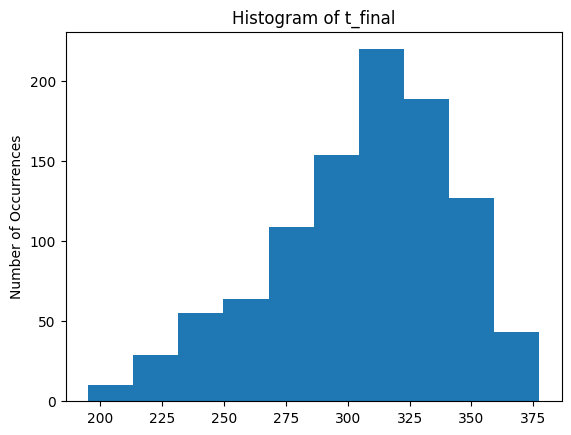

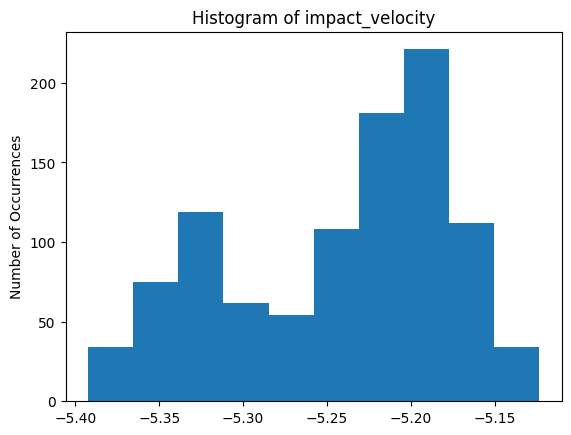

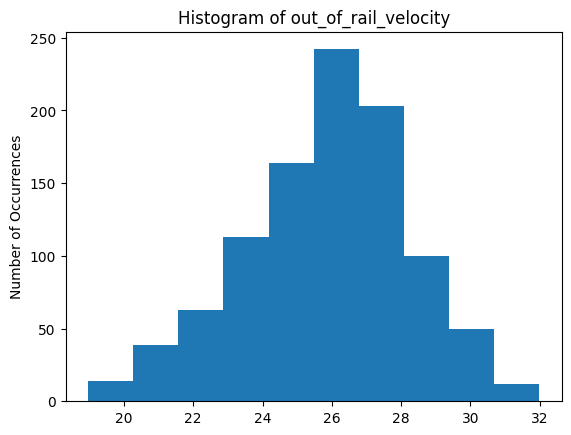

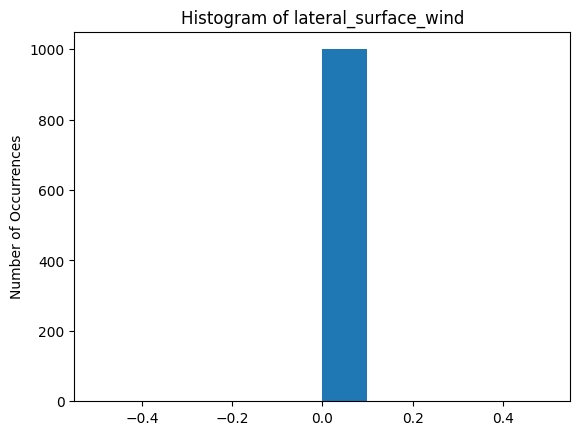

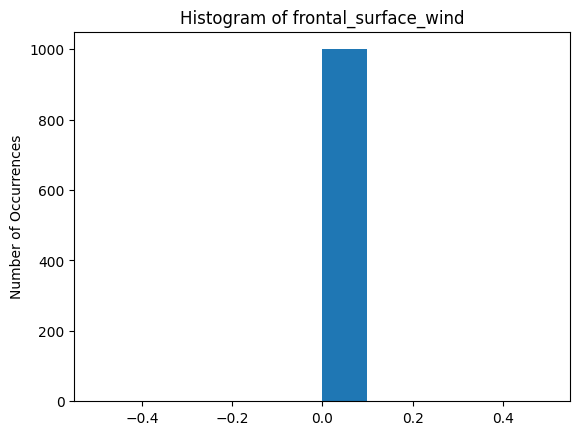

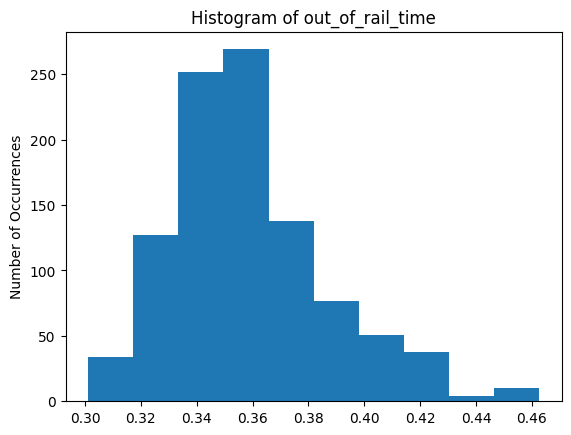

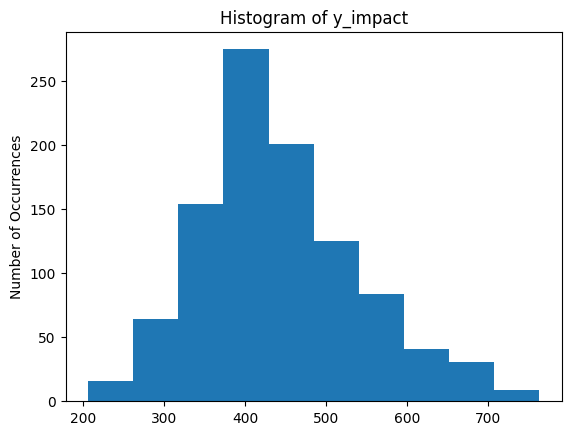

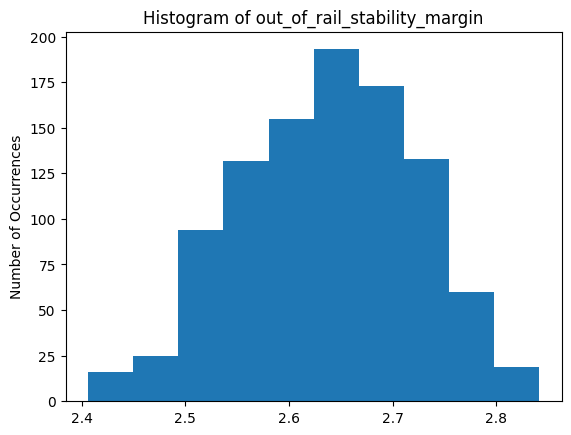

In [20]:
test_dispersion.plots.all()

Finally, one may also export the ellipses to a ``.kml`` file so it can be easily visualized in Google Earth


In [21]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)